In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa import ar_model as smt
from statsmodels.tsa.ar_model import AR
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import datetime
from scipy import stats
import seaborn as sns
from collections import Counter,defaultdict

In [2]:
data = pd.read_csv('D://Desmond/Match/Careerhack/anomaly_detection/dataset/train_data.csv')
result_df = pd.read_csv('D://Desmond/Match/Careerhack/anomaly_detection/dataset/train_output_format_true_ans.csv')


In [3]:
kpi_ls = data.NAME.unique()
len(kpi_ls)

317

In [4]:
# Hyper_parameter
W,N=3,3
OUTLIER_THRESHOLD = 3
MAX_NUMBER = 10
data_before = data[data.time.between('2019-01-01 00:00:00', '2019-11-03 29:59:59')]
data_after = data[data.time.between('2019-11-04 00:00:00', '2019-11-06 23:59:59')]

OVERLAP = True
WINDOW = 8
STRIDE = 1



## Baseline change

In [5]:
def sample(kpi, window=8):
    temp_df = data[data.NAME == kpi]
    sample_mean_ls = [] 
    
    n = len(temp_df)
    
    try:
        baseline_time = result_df[result_df.NAME == kpi].iloc[0][7] 
        idx = np.where(temp_df.time == baseline_time)[0][0]
        idx_sample_baseline_time = int(idx/8)
    except:
        idx_sample_baseline_time = 0 # no baseline change
    
    for i in range(int(n/window)):
        df = temp_df.iloc[window*i:window*(i+1)]
        sample_mean_ls.append(np.mean(df.value))
        
    return sample_mean_ls,idx_sample_baseline_time

In [6]:
def output_continuous_idx(a,n):
    temp_ls=[]
    for i in range(len(a)-n+1):
        button = False
        for t in range(1,n):
            if a[i+t]-a[i+t-1]==1:
                button = True
            else: 
                button =False
                break
        if button:
            temp_ls.append(a[i])
    return temp_ls

In [7]:
def predict_basline_change(kpi,w,n,s=20):
# w : hyperparameter : control width of margin of error
# s : number of steady sample
# n : 超過自定義安全區間連續n次

    sub_sample,baseline_change_idx = sample(kpi)
    
    temp_idx_ls=[] # 超過自定義安全區間
    for i in range(s,len(sub_sample)):
        std = np.std(sub_sample[0:i])
        mean = np.mean(sub_sample[0:i])
        me = w*std
        if (sub_sample[i]>mean+me) or (sub_sample[i]<mean-me) :
            temp_idx_ls.append(i)
    
    output_ls = output_continuous_idx(temp_idx_ls,n)
    
    # select first index
    while len(output_ls)>2:
        output_ls2 = output_continuous_idx(output_ls,2)
        output_ls = output_ls2
    
    return output_ls

In [8]:
def run(test_kpi,w,n):
    a = predict_basline_change(test_kpi,w,n)
#     print(a)

    predict_baseline_idx_ls=[]
    predict_time_ls=[]

    if len(a)<2:
        predict_baseline = 0
    
    else:
        predict_baseline = 1
        if (a[1]-a[0])==1:
            predict_baseline_idx_ls.append(a[0])
        else:
            predict_baseline_idx_ls.append(a[0])
            predict_baseline_idx_ls.append(a[1])

#     print(predict_baseline_idx_ls)
#     print('================')
    
    i = 3
    for predict_idx in predict_baseline_idx_ls:
        temp_df = data[data.NAME == test_kpi]
        predict_time = temp_df.iloc[(predict_idx)*8:(predict_idx+1)*8].time.iloc[i]
        predict_time_ls.append(predict_time)
  

    return predict_baseline,predict_time_ls

In [9]:
def classifier_baseline_change(kpi,w,n):
    predict_baseline_change,predict_time_ls = run(kpi,w,n)
    if predict_time_ls ==[]:
        predict_time = 66
    else:
        predict_time=predict_time_ls[0]
        for i in range(1,len(predict_time_ls)):
            predict_time= predict_time+';'+predict_time_ls[i]
    
    return predict_baseline_change, predict_time

## Fluctuation change

In [10]:
def sample_fluctuation(kpi, window=8):
    temp_df = data[data.NAME == kpi]
    sample_sd_ls = [] 
    
    n = len(temp_df)
    
    try:
        fluctuation_time = result_df[result_df.NAME == kpi].iloc[0][8] 
        idx = np.where(temp_df.time == fluctuation_time)[0][0]
        idx_sample_fluctuation_time = int(idx/window)
    except:
        idx_sample_fluctuation_time = 0 # no baseline change
    
    for i in range(int(n/window)):
        df = temp_df.iloc[window*i:window*(i+1)]
        sample_sd_ls.append(np.std(df.value))
        
    return sample_sd_ls,idx_sample_fluctuation_time

In [11]:
def predict_fluctuation(kpi,w,n,s=20):
# w : hyperparameter : control width of margin of error
# s : number of steady sample
# n : 超過自定義安全區間連續n次

    sub_sample,baseline_change_idx = sample_fluctuation(kpi)
    
    temp_idx_ls=[] # 超過自定義安全區間
    for i in range(s,len(sub_sample)):
        std = np.std(sub_sample[0:i])
        mean = np.mean(sub_sample[0:i])
        me = w*std
        if (sub_sample[i]>mean+me) or (sub_sample[i]<mean-me) :
            temp_idx_ls.append(i)
    
    output_ls = output_continuous_idx(temp_idx_ls,n)
    
    # select first index
    while len(output_ls)>2:
        output_ls2 = output_continuous_idx(output_ls,2)
        output_ls = output_ls2
    
    return output_ls

In [12]:
def run_fluctuation(test_kpi,w,n):
    a = predict_fluctuation(test_kpi,w,n)
#     print(a)

    predict_fluctuation_idx_ls=[]
    predict_time_ls=[]

    if len(a)<2:
        predict_fluct_change = 0
    
    else:
        predict_fluct_change = 1
        if (a[1]-a[0])==1:
            predict_fluctuation_idx_ls.append(a[0])
        else:
            predict_fluctuation_idx_ls.append(a[0])
            predict_fluctuation_idx_ls.append(a[1])

#     print(predict_baseline_idx_ls)
#     print('================')
    
    i = 3
    for predict_idx in predict_fluctuation_idx_ls:
        temp_df = data[data.NAME == test_kpi]
        predict_time = temp_df.iloc[(predict_idx)*8:(predict_idx+1)*8].time.iloc[i]
        predict_time_ls.append(predict_time)
  

    return predict_fluct_change,predict_time_ls

In [13]:
def classifier_fluctuation(kpi,w,n):
    predict_fluctuation_change,predict_time_ls = run_fluctuation(kpi,w,n)
    if predict_time_ls ==[]:
        predict_time = np.nan
    else:
        predict_time=predict_time_ls[0]
        for i in range(1,len(predict_time_ls)):
            predict_time= predict_time+';'+predict_time_ls[i]
    
    return predict_fluctuation_change, predict_time

## Trend

In [14]:
def sliding_window_trend(kpi,target_data,with_ub_lb=0,r_outlier=0,
overlap=False,window=8,knife=0,
stride=0,):

 
    temp_df = target_data[target_data.NAME == kpi]
    temp_value =temp_df.value.to_numpy()
# standrized temp value
    temp_value = (temp_value -np.mean(temp_value)) /np.std(temp_value)
    sample_mean_ls =[]
    ub, lb =[], []
 
    
    
    if r_outlier> 0:
        if len (temp_value[np.abs (temp_value) <= r_outlier])>= 10:
            pass
        else:
            temp_value = temp_value [np.abs (temp_value) <= r_outlier]
 
    n =len(temp_value)
 
    if knife >0:
        window =int(n / knife)
        if window ==0:
            return[],[],[],[]

    # 找是否有 baseline change
    # 若有  則記下  若無  則令為 0
    try:
            baseline_time = result_df[result_df.NAME == kpi].iloc[0][7]
            idx =np.where(temp_df.time == baseline_time)[0][0]
            idx_sample_baseline_time =int(idx/8)
    except:
            idx_sample_baseline_time =0# no baseline change

    # 不重疊
    if overlap ==False:
        if stride >=1:
            sys.exit("stride cant >= 1!!")
        else:
            for i in range(int(n/window)):
                now_value = temp_value[window*i:window*(i+1)]
                now_mean =np.mean(now_value)
                sample_mean_ls.append(now_mean)
        if with_ub_lb >=0:
            ub.append(now_mean + with_ub_lb *np.std(now_value))
            lb.append(now_mean - with_ub_lb *np.std(now_value))


        # 重疊
    else:
    # 檢測 stride 是否 >= 1
        if stride ==0:
            sys.exit("stride should bigger than 0!!")

        step =0# 計數器
        pointer =0# 當前資料指標
        while True:
            if (pointer + window) < n:
                now_value = temp_value[pointer : (pointer + window)]# 取 window 長度資料
                sample_mean_ls.append(np.mean(now_value))# 計算 window mean
                pointer += stride # 將當前 pointer向前stide長度
                step +=1
            else:
        # 若 df = ... 出error 表已經取超出資料長度  迴圈停止
                break
 
    return sample_mean_ls, idx_sample_baseline_time, ub, lb



In [15]:
def classifier_trend(kpi):
    TREND_WINDOW = 20
    data_before = data[data.time.between('2019-01-01 00:00:00', '2019-11-03 29:59:59')]
    data_after = data[data.time.between('2019-11-04 00:00:00', '2019-11-06 23:59:59')]
    # sort result_df as all_KPIs
#     true_sort = [s for s in  if s in result_df.NAME.unique()]
#     sort_result_df = result_df.set_index('NAME').loc[true_sort].reset_index()

    # trend
    trend_ans = []
    trend_status = []
    P_VALUE_THRESHOLD = 1e-07
    SLOPE_THRESHOLD = 0.001
    R2_THRESHOLD = 0.7
    
    for i, kpi in enumerate([kpi]):
        temp,_ ,_,_ = sliding_window_trend(kpi, data, window = TREND_WINDOW)
        slope, intercept, r_value, p_value, std_err = stats.linregress(np.arange(len(temp)),temp)
        if p_value <= P_VALUE_THRESHOLD and np.abs(slope) >= SLOPE_THRESHOLD and r_value**2 >= R2_THRESHOLD:
            trend_ans.append(1)
            if slope >= 0:
                trend_status.append('up')
            else:
                trend_status.append('down')
        else:
            trend_ans.append(0)
            trend_status.append(np.nan)

    temp_df = data[data.NAME == kpi]
    start_time = temp_df.iloc[0][1]
    end_time = temp_df.iloc[-1][1]

    return trend_ans[0], trend_status[0], start_time, end_time 

## Outlier

In [16]:
# 輸入 kpi, trend_ans, baseline_ans,  此二ans為 0 or 1
# 用法: bool, list = Outlier(), bool為 0 1 表是否有outlier
# 若 bool = 0 則 list 輸出空list, []
# 若 bool = 1 則 list 輸出時間 ['time'], 可能有2個以上


def classifier_outlier(kpi, trend_ans, baseline_ans):
    if trend_ans == 1 or baseline_ans == 1:
        now_df = data_after[data_after.NAME == kpi]
        now_data = now_df.value.to_numpy()
        after_pos = 0
    else:
        now_df = data[data.NAME == kpi]
        now_data = now_df.value.to_numpy()
        after_pos_time = now_df[now_df.time.between('2019-11-04 00:00:00', '2019-11-06 23:59:59')].time.to_list()[0]
        after_pos = np.where(now_df.time.to_numpy() == after_pos_time)[0][0]

    now_data = (now_data - np.mean(now_data)) / np.std(now_data)
    now_data_outlier_pos = np.where(now_data >= OUTLIER_THRESHOLD)[0]

    if MAX_NUMBER >= len(now_data_outlier_pos) > 0:
        now_data_outlier_pos = now_data_outlier_pos[now_data_outlier_pos >= after_pos]
        outliers = now_df.iloc[now_data_outlier_pos]
        print(outliers)

        if len(outliers) > 0:
#             ans.append(1)
#             ans.append(outliers.time.to_list())
            return 1, outliers.time.tolist()
        else:
            return 0, np.nan
    else:
        return 0, np.nan

In [17]:
empty = np.nan
def model_gg(kpi):
#     final_output_ls=[kpi,1,0,0,0,0,empty,empty,empty,empty]
    output_dict={'NAME':kpi,'Normal':0,'Outlier':0,'Baseline_change':0,
                'Fluctuation':0,'Trend':0,'Outlier_time':empty,
                 'Baseline_time':empty,'Fluctuation_time':empty,
                'Trend_status':empty,'Trend_start':empty,'Trend_end':empty}
    
    # Layer 1
#     predict_normal = classifier_normal(kpi)
#     if predict_normal == 1:
#         pass
#     else :
    # Layer 2 
    output_dict['Baseline_change'], output_dict['Baseline_time'] = classifier_baseline_change(kpi,w=3,n=3) # true/false date
#     output_dict['Fluctuation'], output_dict['Fluctuation_time'] = classifier_fluctuation(kpi,w=3,n=3)
#     output_dict['Trend'],output_dict['Trend_status'], output_dict['Trend_start'],output_dict['Trend_end'] = classifier_trend(kpi)
#     output_dict['Outlier'], output_dict['Outlier_time'] = classifier_outlier(kpi, output_dict['Trend'],output_dict['Baseline_change'] )
    
#     if (output_dict['Baseline_change']==0) and (output_dict['Baseline_change']==0) and (output_dict['Baseline_change']==0) and (output_dict['Baseline_change']==0):
#         output_dict['Normal']==1
    return output_dict

## Normal

In [18]:
def sliding_window_normal(kpi, overlap = False, window = 8, stride = 0):
    '''
        overlap : 是否啟用重疊區間
        window : 區間長度
        stride : 若 overlap == true 則設定重疊長度
    '''
    
    temp_df = data[data.NAME == kpi]
    sample_mean_ls = [] 
    
    n = len(temp_df)
    
    # 找是否有 baseline change
    # 若有  則記下  若無  則令為 0
    try:
        baseline_time = result_df[result_df.NAME == kpi].iloc[0][8] 
        idx = np.where(temp_df.time == baseline_time)[0][0]
        idx_sample_baseline_time = int(idx/window)
    except:
        idx_sample_baseline_time = 0 # no baseline change

    # 不重疊
    if overlap == False:
        if stride >= 1:
            sys.exit("stride cant >= 1!!")
        else:
            for i in range(int(n/window)):
                df = temp_df.iloc[window*i:window*(i+1)]
                sample_mean_ls.append(np.mean(df.value))
                
    # 重疊
    else:
        # 檢測 stride 是否 >= 1
        if stride == 0:
            sys.exit("stride should bigger than 0!!")
        
        step = 0 # 計數器
        pointer = 0 # 當前資料指標
        while True:
            if (pointer + window) < n:
                df = temp_df.iloc[pointer : (pointer + window)] # 取 window 長度資料
                sample_mean_ls.append(np.mean(df.value)) # 計算 window mean
                pointer += stride # 將當前 pointer向前stide長度
                step += 1
            else:
                # 若 df = ... 出error 表已經取超出資料長度  迴圈停止
                break

    return sample_mean_ls, idx_sample_baseline_time

===== Hyerparameter =====
Window: 8
Stride: 2


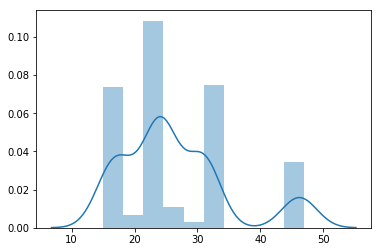

In [19]:
WINDOW, STRIDE = 8,2
lag_list = []
counter = 0
print('===== Hyerparameter =====')
print('Window: ' + str(WINDOW))
print('Stride: ' + str(STRIDE))
for i in kpi_ls:
    temp_ls, _ = sliding_window_normal(i, overlap = OVERLAP, window = WINDOW, stride = STRIDE)
    model = AR(temp_ls)
    model_fit = model.fit()
    best_lag = model_fit.k_ar
    lag_list.append(best_lag)
#     print([i, best_lag])

sns.distplot(lag_list)

In [ ]:
# sort result_df in order to match all_KPIs
normal_ans = []
for i in kpi_ls:
    now = result_df[result_df.NAME == i].Normal.values.tolist()
    normal_ans.extend(now)

## Result

In [20]:
result_dict = defaultdict(list)

for i,r in result_df.iterrows():
    result_dict['nor_t'].append(r[1])
    result_dict['out_t'].append(r[2])
    result_dict['base_t'].append(r[3])
    result_dict['fluc_t'].append(r[4])
    result_dict['trend_t'].append(r[5])
    
    TEST_KPI = r[0]
    t_base, _=classifier_baseline_change(TEST_KPI,W,N)
    t_fluc, _=classifier_fluctuation(TEST_KPI,W,N)
    t_trend,_,_,_ = classifier_trend(TEST_KPI)
    t_out,_ = classifier_outlier(TEST_KPI, t_trend, t_base)
    result_dict['out_p'].append(t_out)
    result_dict['base_p'].append(t_base)
    result_dict['fluc_p'].append(t_fluc)
    result_dict['trend_p'].append(t_trend)
    if (t_base==1) | (t_fluc==1) | (t_trend==1) | (t_out==1):
        result_dict['nor_p'].append(0)
    else: 
        result_dict['nor_p'].append(1)

               NAME                 time  value
995684  KPI_3213764  2019-11-04 23:05:11  19.58
               NAME                 time  value
344264  KPI_3470339  2019-11-04 03:58:04   5.54
344504  KPI_3470339  2019-11-06 18:28:05   5.06
               NAME                 time  value
818757  KPI_2718449  2019-11-06 00:13:02   5.35
               NAME                 time  value
228866  KPI_1517697  2019-11-04 12:30:10  24.72
228971  KPI_1517697  2019-11-04 21:15:10  25.32
229304  KPI_1517697  2019-11-06 01:00:10  24.83
229550  KPI_1517697  2019-11-06 21:30:07  25.50
Empty DataFrame
Columns: [NAME, time, value]
Index: []
Empty DataFrame
Columns: [NAME, time, value]
Index: []
              NAME                 time  value
9108  SYS_27200989  2019-11-04 22:50:00  306.0
Empty DataFrame
Columns: [NAME, time, value]
Index: []
               NAME                 time   value
1349975  KPI_933885  2019-11-04 08:25:25  15.770
1349976  KPI_933885  2019-11-04 08:30:15  21.107
1349977  KPI_93388

D:\Programming\Python\Anaconda\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
D:\Programming\Python\Anaconda\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in greater_equal


               NAME                 time  value
824862  KPI_2718479  2019-11-05 22:28:02   5.17
                NAME                 time  value
125953  SYS_27200977  2019-11-05 01:00:00  0.181
125980  SYS_27200977  2019-11-05 05:30:00  0.191
126029  SYS_27200977  2019-11-05 13:40:00  0.176
126182  SYS_27200977  2019-11-06 15:40:00  0.177


D:\Programming\Python\Anaconda\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
D:\Programming\Python\Anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
D:\Programming\Python\Anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
D:\Programming\Python\Anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


Empty DataFrame
Columns: [NAME, time, value]
Index: []
Empty DataFrame
Columns: [NAME, time, value]
Index: []
                NAME                 time  value
32889  SYS_105141032  2019-11-06 19:52:56   62.0
32890  SYS_105141032  2019-11-06 19:57:51   64.0
             NAME                 time  value
216893  SYS_68542  2019-11-06 02:10:00   65.0
216894  SYS_68542  2019-11-06 02:20:00   62.0
216895  SYS_68542  2019-11-06 02:30:00  100.0
216897  SYS_68542  2019-11-06 02:50:00  104.0
216898  SYS_68542  2019-11-06 03:00:00   68.0
216906  SYS_68542  2019-11-06 04:20:00   67.0
               NAME                 time  value
138582  KPI_3495607  2019-11-04 21:40:17   12.0
138641  KPI_3495607  2019-11-05 07:30:24   15.0
               NAME                 time  value
385283  KPI_3701746  2019-11-04 04:50:55  59.85
Empty DataFrame
Columns: [NAME, time, value]
Index: []
               NAME                 time  value
834875  KPI_2718586  2019-11-05 23:00:23  25.41
               NAME           

In [21]:
def print_result(ls_t,ls_p):
    tn, fp, fn, tp = confusion_matrix(ls_t,ls_p).ravel()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = 2*precision*recall/(precision+recall)
    print('precision:',precision)
    print('recall:',recall)
    print('f1:',f1)
    return f1

In [22]:
print('Normal')
f_nor=print_result(result_dict['nor_t'],result_dict['nor_p'])
print('==========')
print('Outlier')
f_out=print_result(result_dict['out_t'],result_dict['out_p'])
print('==========')
print('Baseline_change')
f_base=print_result(result_dict['base_t'],result_dict['base_p'])
print('==========')
print('Fluctuation')
f_fluc=print_result(result_dict['fluc_t'],result_dict['fluc_p'])
print('==========')
print('Trend')
f_trend=print_result(result_dict['trend_t'],result_dict['trend_p'])
print('==========')
print('f1 : ',np.average([f_base,f_fluc,f_nor,f_out,f_trend]))

Normal
precision: 0.9247787610619469
recall: 0.8818565400843882
f1: 0.9028077753779699
Outlier
precision: 0.38095238095238093
recall: 0.32
f1: 0.34782608695652173
Baseline_change
precision: 0.35185185185185186
recall: 0.9047619047619048
f1: 0.5066666666666666
Fluctuation
precision: 0.6363636363636364
recall: 0.4375
f1: 0.5185185185185185
Trend
precision: 0.9032258064516129
recall: 1.0
f1: 0.9491525423728813
f1 :  0.6449943179785116
